In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!mkdir rm -r LAB_JORGE_RODRIGO
!mkdir LAB_JORGE_RODRIGO
!gsutil -m cp -r drive/MyDrive/Colab\ Notebooks/IMAGE/Celebrity-Face-Recognition/* LAB_JORGE_RODRIGO/

#!mkdir LAB_JORGE_RODRIGO/105_classes_pins_dataset
#!gsutil -m cp -r drive/MyDrive/Colab\ Notebooks/IMAGE/Celebrity-Face-Recognition/105_classes_pins_dataset/* LAB_JORGE_RODRIGO/105_classes_pins_dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
Copying file://drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/105_classes_pins_dataset/pins_Katherine Langford/Katherine Langford220_2990.jpg...
Copying file://drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/105_classes_pins_dataset/pins_Katherine Langford/Katherine Langford174_2950.jpg...
Copying file://drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/105_classes_pins_dataset/pins_Katherine Langford/Katherine Langford50_3047.jpg...
Copying file://drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/105_classes_pins_dataset/pins_Katherine Langford/Katherine Langford210_2982.jpg...
Copying file://drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/105_classes_pins_dataset/pins_Katherine Langford/Katherine Langford13_2900.jpg...
Copying file://drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/105_classes_pins_dataset/pins_Katherine Langford/Katherine

In [3]:
!pip install livelossplot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os
work_dir = "LAB_JORGE_RODRIGO"
train_dir = os.path.join(work_dir,'training')       #Path of train directory. 
test_dir = os.path.join(work_dir,'test')
val_dir = os.path.join(work_dir,'validation')          #Path of test directory.
os.makedirs(train_dir, exist_ok=True)  #Creating a directory for training examples. 
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)    #Creating a directory for testing examples. 

In [5]:
train_ratio=0.8
val_ratio=0.1
test_ratio=0.1
dir_list=os.listdir(os.path.join(work_dir ,'105_classes_pins_dataset'))
print('The Number of Classes in the Dataset is:{}'.format(len(dir_list)))

#This Code will split up the unzipped dataset into training and testing set with respect to the values of train_ratio and test_ratio.
from shutil import copyfile
import numpy as np

source_dir = os.path.join(work_dir ,'105_classes_pins_dataset')        #Unzipped dataset directory 

dir_list = os.listdir(source_dir)

for folder in dir_list:
  if folder != ".DS_Store":
    data_dir = os.listdir(os.path.join(source_dir,folder))
    np.random.shuffle(data_dir)                            #Shuffling the examples of the classes inside the dataset.
    os.makedirs(os.path.join(train_dir , folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir , folder), exist_ok=True)
    train_data = data_dir[:int(len(data_dir)*train_ratio+1)] #Splitting the training dataset with respect to the train_ratio.
    val_data = data_dir[-int(len(data_dir)*val_ratio):]
    test_data = data_dir[-int(len(data_dir)*test_ratio):]
  
    for image in train_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(train_dir,folder,image)) #Copying the Training files from dataset to training directory.
    
    for image in val_data:
       copyfile(os.path.join(source_dir,folder,image) , os.path.join(val_dir,folder,image))  #Copying the Training files from dataset to training directory.

    #for image in test_data:
    #   copyfile(os.path.join(source_dir,folder,image) , os.path.join(test_dir,folder,image)) 
    

The Number of Classes in the Dataset is:106


In [6]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/runs/model.h5"
# Local code in: D:\Desktop_ANA_LeNovo\CLASES_UNIVERSIDAD\LABS\IMAGE\image_classifier-master
# Data path = "D://Desktop_ANA_LeNovo/CLASES_UNIVERSIDAD/LABS/IMAGE/dogs-vs-cats/" #20.000 files ruta
#path = "LAB_JORGE_RODRIGO/"
#training_data_dir = path + "training" # 10 000 * 2
#validation_data_dir = path + "validation" # 2 500 * 2
#test_data_dir = path + "test" # 12 500

In [7]:
# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 50
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [8]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='linear', input_shape=input_shape))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='linear'))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='linear'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(105, activation='softmax'))

model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))


In [9]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [10]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    val_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="categorical", 
    shuffle=False)

Found 14084 images belonging to 105 classes.
Found 1703 images belonging to 105 classes.
Found 0 images belonging to 0 classes.


In [11]:
# Training
result=model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[CSVLogger(TRAINING_LOGS_FILE,append=False,separator=";")], 
    verbose=1)
model.save_weights(MODEL_FILE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
440/440 [==============================] - 157s 319ms/step - loss: 0.1117 - accuracy: 0.0130 - val_loss: 0.0529 - val_accuracy: 0.0324
Epoch 2/50
440/440 [==============================] - 138s 313ms/step - loss: 0.0520 - accuracy: 0.0507 - val_loss: 0.0487 - val_accuracy: 0.0884
Epoch 3/50
440/440 [==============================] - 137s 311ms/step - loss: 0.0480 - accuracy: 0.1000 - val_loss: 0.0469 - val_accuracy: 0.1309
Epoch 4/50
440/440 [==============================] - 138s 313ms/step - loss: 0.0451 - accuracy: 0.1504 - val_loss: 0.0451 - val_accuracy: 0.1409
Epoch 5/50
440/440 [==============================] - 138s 314ms/step - loss: 0.0427 - accuracy: 0.1996 - val_loss: 0.0440 - val_accuracy: 0.1846
Epoch 6/50
440/440 [==============================] - 137s 312ms/step - loss: 0.0404 - accuracy: 0.2454 - val_loss: 0.0432 - val_accuracy: 0.2034
Epoch 7/50
440/440 [==============================] - 137s 312ms/step - loss: 0.0382 - accuracy: 0.2957 - val_loss: 0.0465 -

In [12]:
#model.save_weights(MODEL_FILE)
model.save(MODEL_FILE)

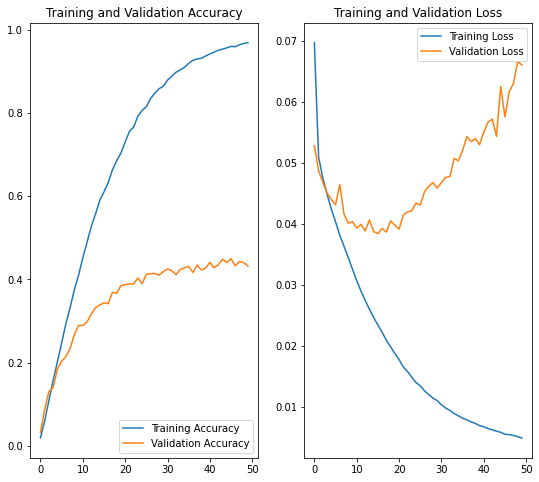

In [13]:
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
plt.savefig('drive/MyDrive/Colab Notebooks/IMAGE/Celebrity-Face-Recognition/runs/SimpleModel.png')

<Figure size 432x288 with 0 Axes>